## load dependency and args

In [23]:
#!/usr/bin/env python
import argparse
import builtins
import os
import shutil
import copy
import numpy as np

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim
import torchvision.models as models

import sys
sys.path.extend(['..', '.'])
from datasets.dataset_tinyimagenet import load_train, load_val_loader, num_classes_dict
from tools.store import ExperimentLogWriter
import models.builder as model_builder
import utils

from sklearn.cluster import KMeans
from collections import Counter

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))
model_names += ['resnet18_cifar_variant1']

args = argparse.Namespace(
    dataset='cifar10',
    arch='resnet18_cifar_variant1',
    workers=1,
    epochs=100,
    start_epoch=0,
    batch_size=256,
    lr=30.0,
    schedule=[60, 80],
    momentum=0.9,
    weight_decay=0.0,
    print_freq=10,
    evaluate=False,
    world_size=-1,
    rank=-1,
    dist_url='tcp://224.66.41.62:23456',
    dist_backend='nccl',
    seed=None,
    gpu=None,
    multiprocessing_distributed=False,
    opt='sgd',
    dir='log/spectral/completed-2023-05-13spectral-resnet18-mlp1000-norelu-cifar10-lr003-mu1-log_freq:20',
    num_per_class=int(1e10),
    val_every=5,
    latest_only=True,
    mpd=False,
    dist_url_add=0,
    specific_ckpts=None,
    use_random_labels=False,
    normalize=False,
    nomlp=True,
    aug='standard',
    download=True
)


## Without retraining, load calculated embedding

In [24]:
# Check if the file exists
file_path = "data/embeddings_10.pt"
if not os.path.exists(file_path):
    print("Embeddings file not found.")
else:
    # Load the embeddings tensor from the file
    embeddings = torch.load(file_path)

    # Print the shape or any other desired information about the loaded embeddings
    print("Loaded embeddings shape:", embeddings.shape)

Loaded embeddings shape: torch.Size([50000, 10])


## Define functions for flipping experiment
### 1. flip a certain number of data points in the train set
### 2. generate embeddings for all points in train set
### 3. perform K-means into 2r clusters (r is the number of classes)
### 4. use marjority vote in each clusters to determine mislabels

In [25]:
def flip_labels(labels, num_classes=10, noise_level=0.1):
    total_labels = len(labels)

    # Set diagonal to 1 - noise level
    prob_matrix = np.full((num_classes, num_classes), (noise_level) / (num_classes - 1))
    np.fill_diagonal(prob_matrix, 1 - noise_level)

    original_labels = labels.copy()
    flipped_indices = []

    for idx, label in enumerate(labels):
        # The probabilities are obtained from the corresponding row in the prob_matrix
        probabilities = prob_matrix[label]

        # The new label is chosen according to these probabilities
        new_label = np.random.choice(num_classes, p=probabilities)
        
        if new_label != label:
            flipped_indices.append(idx)
            
        labels[idx] = new_label

    return labels, flipped_indices, original_labels




def get_majority_vote_label(labels):
    label_counts = Counter(labels)
    return label_counts.most_common(1)[0][0]

def calculate_accuracy(predicted_labels, actual_labels):
    correct_predictions = (np.array(predicted_labels) == np.array(actual_labels)).sum()
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy

In [26]:
def load_labels(train_loader):
    labels = []
    for _, label in train_loader:
        labels.extend(label.tolist())
    return labels

In [27]:
# Load and build the model
# loop through checkpoints and set pre-trained
ckpt_dir = os.path.join(args.dir, 'checkpoints')
for fname in sorted(os.listdir(ckpt_dir)):
    if args.latest_only and not fname.startswith('latest_'): continue
    if args.specific_ckpts is not None and fname not in args.specific_ckpts: continue
    args.pretrained = os.path.join(ckpt_dir, fname)
args.distributed = False

model = model_builder.get_model(num_classes_dict[args.dataset], arch=args.arch)
# load from pre-trained, before DistributedDataParallel constructor
if args.pretrained:
    if os.path.isfile(args.pretrained):
        checkpoint = torch.load(args.pretrained, map_location='cpu')
        state_dict = checkpoint['state_dict']
        model_builder.load_checkpoint(model, state_dict, args.pretrained, args=args, nomlp=args.nomlp)
    else:
        print("=> no checkpoint found at '{}'".format(args.pretrained))

=> loading checkpoint 'log/spectral/completed-2023-05-13spectral-resnet18-mlp1000-norelu-cifar10-lr003-mu1-log_freq:20/checkpoints/latest_800.pth'
=> loaded pre-trained model 'log/spectral/completed-2023-05-13spectral-resnet18-mlp1000-norelu-cifar10-lr003-mu1-log_freq:20/checkpoints/latest_800.pth'


In [28]:
random_labels = None
train_sampler, train_loader = load_train(args.dataset, args.num_per_class, args.distributed,
                                         args.batch_size, args.workers, data_aug=args.aug, random_labels=random_labels)

# Load original labels
original_labels = load_labels(train_loader)
    

In [29]:
# Flip labels
labels, flip_indices, original_labels = flip_labels(original_labels, noise_level=0.1, num_classes=10)

In [30]:
num_different_elements = sum(1 for x, y in zip(labels, original_labels) if x != y)
print("Number of different labels:", num_different_elements)

Number of different labels: 4920


## Define the number of clusters



In [31]:
num_classes = len(set(labels)) # 10
num_clusters = num_classes*10

## Run K-means

#clusters = 100 * #classes, i.e. 1000 clusters, 50 images in each cluster in average

In [32]:
kmeans_100 = KMeans(n_clusters=num_clusters, random_state=0).fit(embeddings)

/Users/jinhuang/opt/miniconda3/envs/spectral/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [33]:
for cluster in range(num_clusters):
    cluster_indices = np.where(kmeans_100.labels_ == cluster)[0]
    cluster_indices = cluster_indices.astype(int)

    cluster_labels = np.array(labels)[cluster_indices]
    majority_vote_label = get_majority_vote_label(cluster_labels)

    # Get counts of original labels
    original_label_counts = Counter(np.array(labels)[cluster_indices])

    # Plot original label counts
    plt.figure(figsize=(5, 4))
    plt.bar(original_label_counts.keys(), original_label_counts.values(), color='b')
    plt.title(f'Original Labels for Cluster {cluster}')
    plt.xlabel('Label')
    plt.ylabel('Count')

    # Check if the cluster contains any mislabeled points
    mislabeled_in_cluster = set(cluster_indices) & set(flip_indices)
    if mislabeled_in_cluster:
        mislabeled_label_counts = Counter(np.array(labels)[list(mislabeled_in_cluster)])
        plt.bar(mislabeled_label_counts.keys(), mislabeled_label_counts.values(), color='r', alpha=0.5)
    plt.tight_layout()
    plt.show()

    if cluster > 20:
        break


/var/folders/0y/shz8c0dx1qd_g2zk_q5v5k3w0000gn/T/ipykernel_77672/267200429.py:24: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/var/folders/0y/shz8c0dx1qd_g2zk_q5v5k3w0000gn/T/ipykernel_77672/267200429.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5, 4))


## Visualization of clusters 

In [34]:
# Reduce dimensionality for visualization
embeddings_2d = TSNE(n_components=2).fit_transform(embeddings)

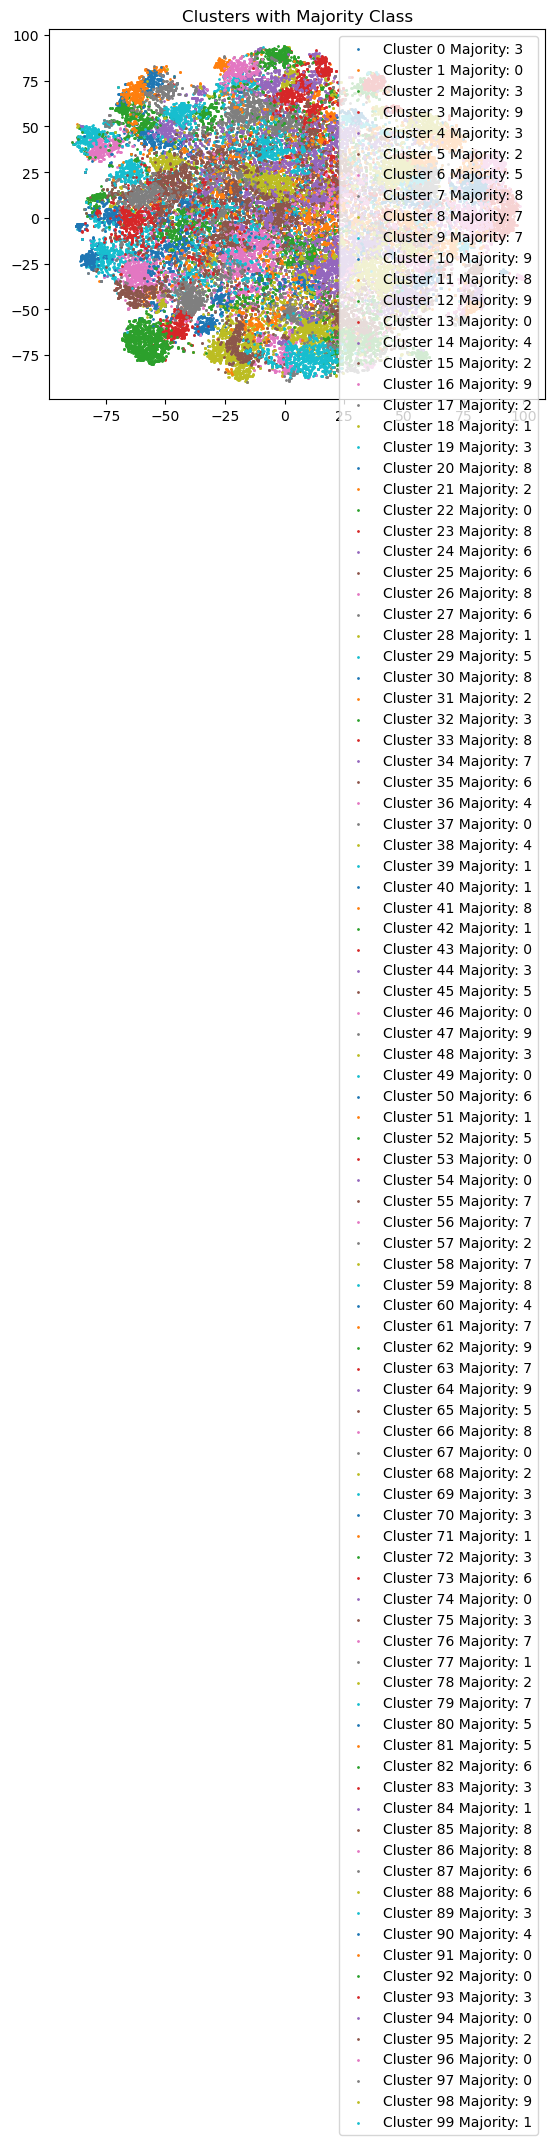

In [41]:
%matplotlib inline
# Detect mislabeled data points
predicted_labels = []
for cluster in range(num_clusters):
    cluster_indices = np.where(kmeans_100.labels_ == cluster)[0]
    cluster_indices = cluster_indices.astype(int)
    
    cluster_labels = np.array(labels)[cluster_indices]

    majority_vote_label = get_majority_vote_label(cluster_labels)

    predicted_labels.extend([majority_vote_label]*len(cluster_labels))

    # Plot each cluster
    plt.scatter(embeddings_2d[cluster_indices, 0], embeddings_2d[cluster_indices, 1], label=f"Cluster {cluster} Majority: {majority_vote_label}", s=1)

plt.title("Clusters with Majority Class")
plt.legend()
plt.show()

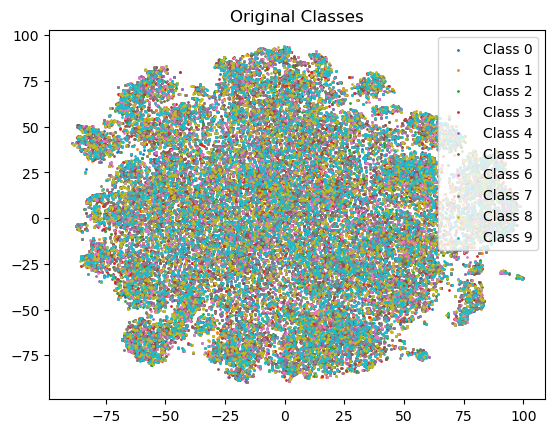

In [42]:
# Create a scatter plot with original labels
for label in set(original_labels):
    indices = np.where(np.array(original_labels) == label)[0]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=f"Class {label}", s=1)  # Set s to a smaller value, such as 10

plt.title("Original Classes")
plt.legend()
plt.show()

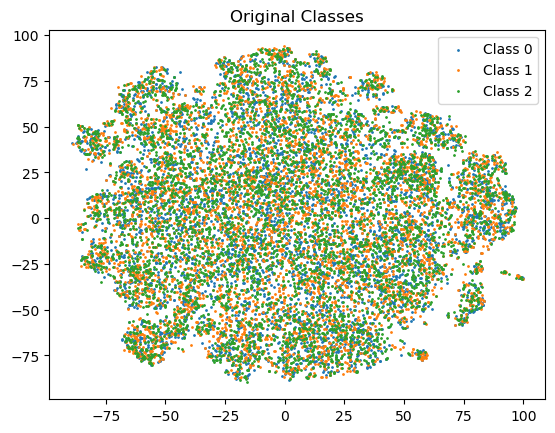

In [48]:
# Create a scatter plot with original labels
for label in set(original_labels):
    indices = np.where(np.array(original_labels) == label)[0]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=f"Class {label}", s=1)  # Set s to a smaller value, such as 10
    if label > 1:
        break

plt.title("Original Classes")
plt.legend()
plt.show()

In [43]:
num_classes = len(set(labels)) # 10
num_clusters = num_classes*1000 # 10000

In [44]:
kmeans_10000 = KMeans(n_clusters=num_clusters, random_state=0).fit(embeddings)

/Users/jinhuang/opt/miniconda3/envs/spectral/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


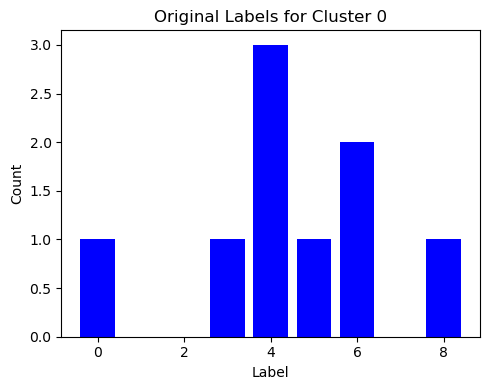

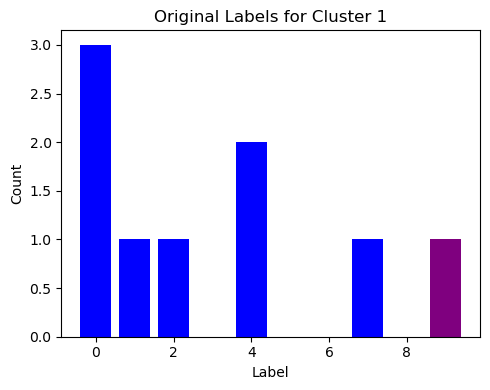

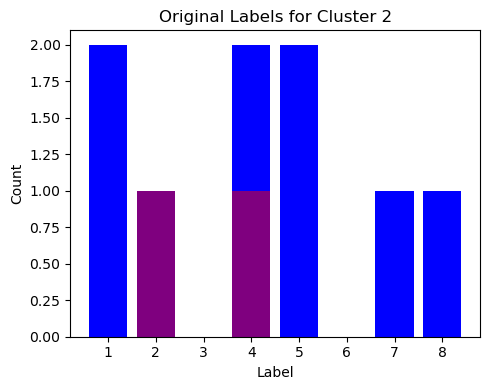

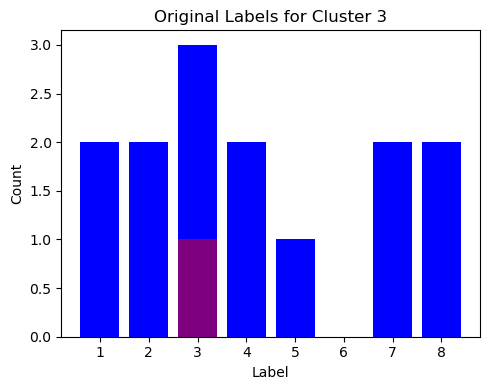

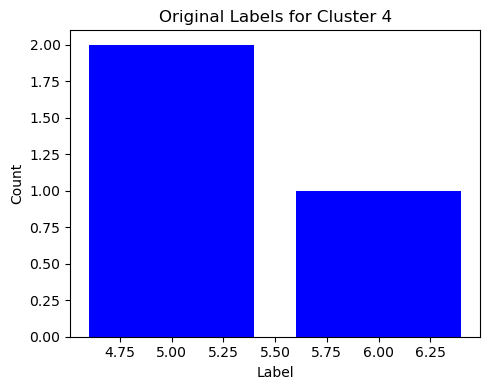

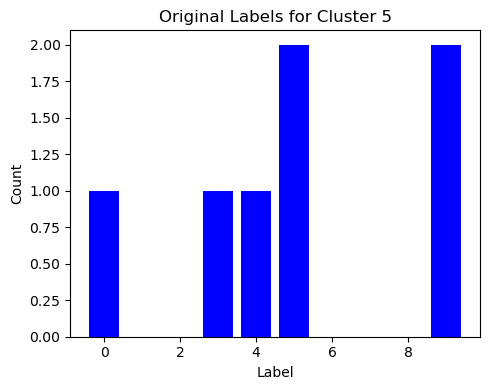

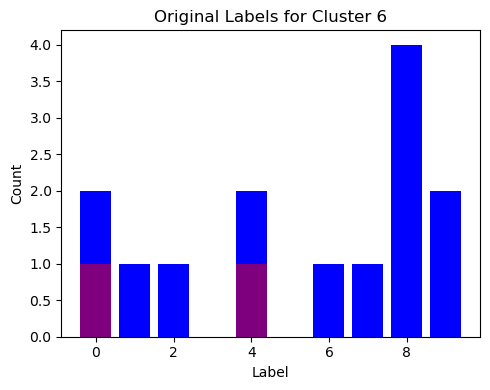

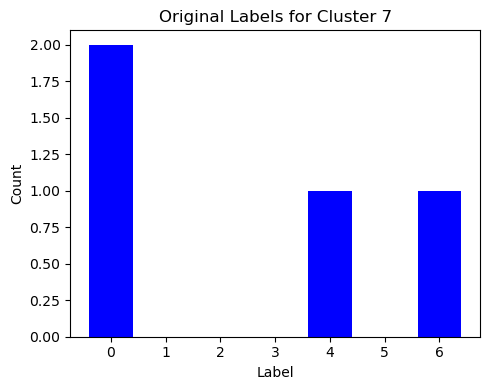

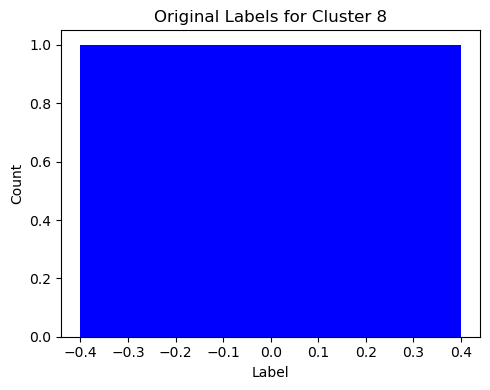

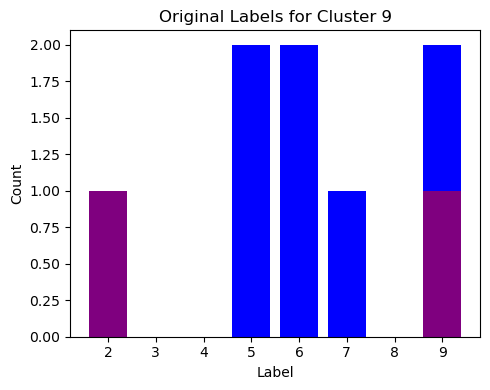

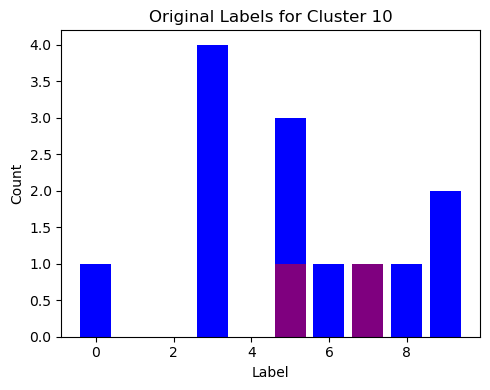

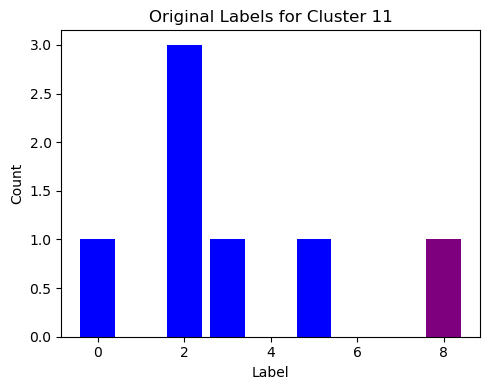

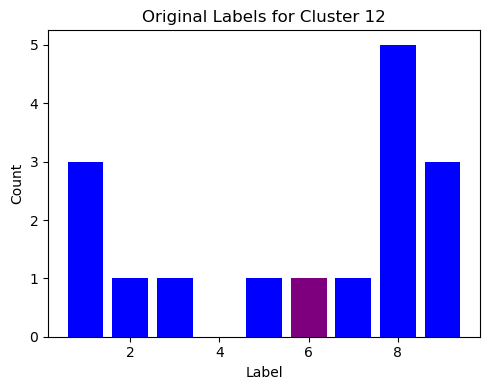

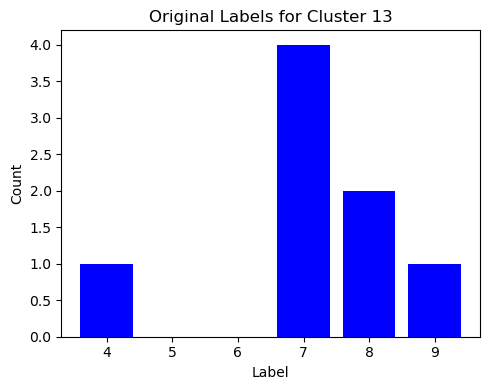

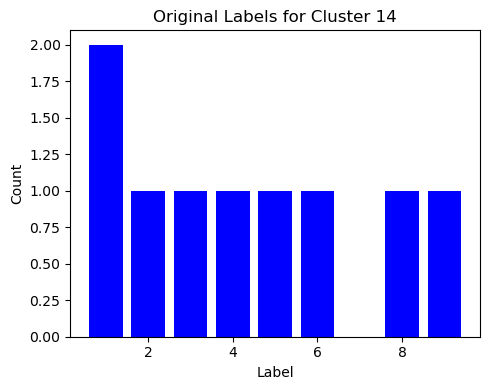

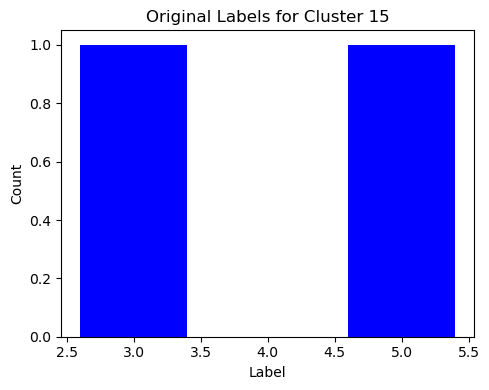

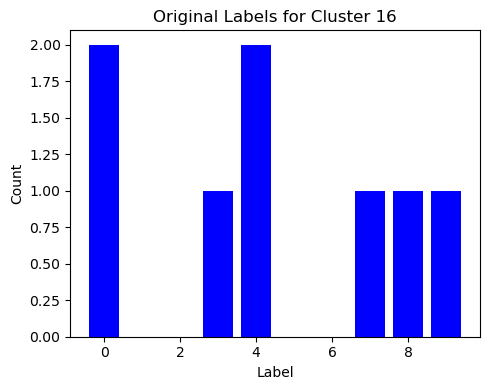

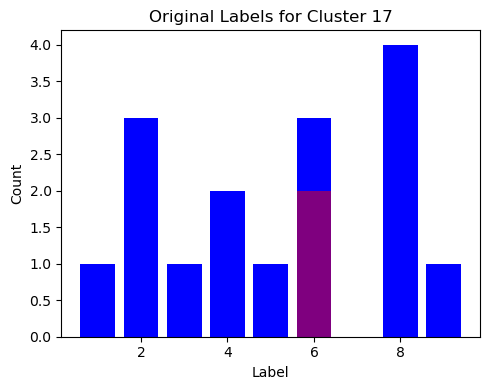

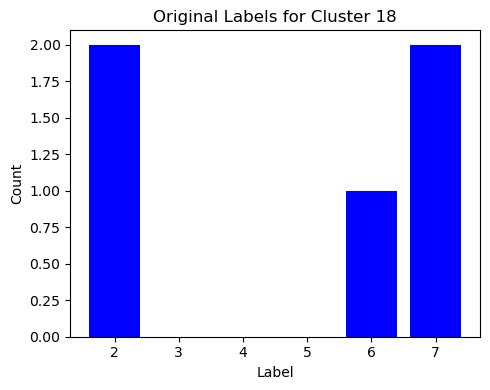

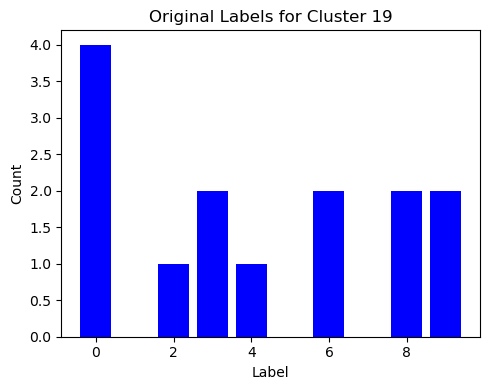

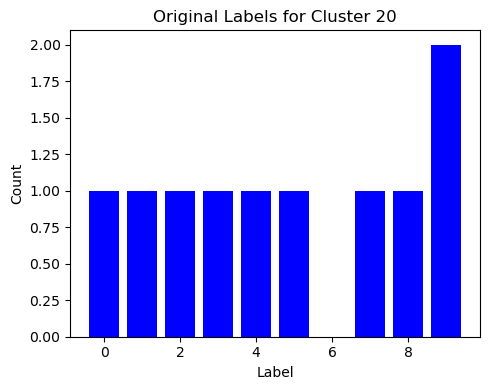

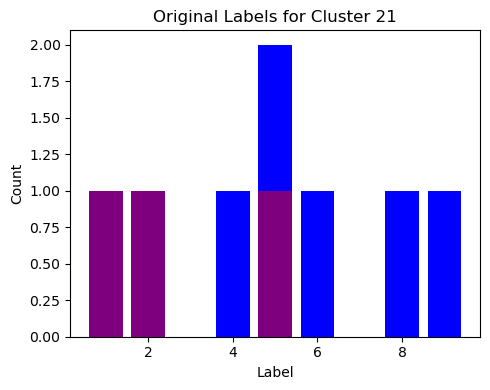

In [45]:
for cluster in range(num_clusters):
    cluster_indices = np.where(kmeans_10000.labels_ == cluster)[0]
    cluster_indices = cluster_indices.astype(int)

    cluster_labels = np.array(labels)[cluster_indices]
    majority_vote_label = get_majority_vote_label(cluster_labels)

    # Get counts of original labels
    original_label_counts = Counter(np.array(labels)[cluster_indices])

    # Plot original label counts
    plt.figure(figsize=(5, 4))
    plt.bar(original_label_counts.keys(), original_label_counts.values(), color='b')
    plt.title(f'Original Labels for Cluster {cluster}')
    plt.xlabel('Label')
    plt.ylabel('Count')

    # Check if the cluster contains any mislabeled points
    mislabeled_in_cluster = set(cluster_indices) & set(flip_indices)
    if mislabeled_in_cluster:
        mislabeled_label_counts = Counter(np.array(labels)[list(mislabeled_in_cluster)])
        plt.bar(mislabeled_label_counts.keys(), mislabeled_label_counts.values(), color='r', alpha=0.5)
    plt.tight_layout()
    plt.show()

    if cluster > 20:
        break

## Detect mislabel

In [46]:
# Detect mislabeled data points
predicted_labels = []
for cluster in range(num_classes*2):
    cluster_indices = np.where(kmeans_10000.labels_ == cluster)[0]
    cluster_indices = cluster_indices.astype(int)
    
#     print(f"{cluster_indices = }")
    cluster_labels = np.array(labels)[cluster_indices]

    print(f"{cluster_labels = }")

    majority_vote_label = get_majority_vote_label(cluster_labels)

    print(f"{majority_vote_label = }")

    predicted_labels.extend([majority_vote_label]*len(cluster_labels))



cluster_labels = array([4, 0, 6, 4, 3, 8, 5, 6, 4])
majority_vote_label = 4
cluster_labels = array([4, 0, 0, 2, 7, 0, 9, 1, 4])
majority_vote_label = 0
cluster_labels = array([4, 2, 7, 1, 5, 4, 8, 5, 1])
majority_vote_label = 4
cluster_labels = array([3, 8, 1, 1, 2, 3, 7, 2, 3, 4, 5, 7, 8, 4])
majority_vote_label = 3
cluster_labels = array([5, 5, 6])
majority_vote_label = 5
cluster_labels = array([9, 4, 9, 5, 3, 0, 5])
majority_vote_label = 9
cluster_labels = array([9, 9, 1, 8, 8, 7, 4, 2, 4, 6, 0, 8, 8, 0])
majority_vote_label = 8
cluster_labels = array([0, 0, 6, 4])
majority_vote_label = 0
cluster_labels = array([0])
majority_vote_label = 0
cluster_labels = array([6, 5, 2, 6, 9, 9, 5, 7])
majority_vote_label = 6
cluster_labels = array([0, 3, 3, 8, 7, 6, 9, 5, 3, 9, 5, 3, 5])
majority_vote_label = 3
cluster_labels = array([2, 0, 5, 8, 3, 2, 2])
majority_vote_label = 2
cluster_labels = array([8, 9, 8, 8, 1, 3, 8, 7, 5, 9, 9, 2, 1, 1, 6, 8])
majority_vote_label = 8
cluster_labels = arra

In [47]:
# Calculate accuracy
print(f"{(np.array(predicted_labels) == np.array(original_labels)) = }")

accuracy = calculate_accuracy(predicted_labels, original_labels)
print(f"Accuracy: {accuracy}")

(np.array(predicted_labels) == np.array(original_labels)) = False


/var/folders/0y/shz8c0dx1qd_g2zk_q5v5k3w0000gn/T/ipykernel_77672/91834331.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(f"{(np.array(predicted_labels) == np.array(original_labels)) = }")
/var/folders/0y/shz8c0dx1qd_g2zk_q5v5k3w0000gn/T/ipykernel_77672/1146560892.py:33: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  correct_predictions = (np.array(predicted_labels) == np.array(actual_labels)).sum()


AttributeError: 'bool' object has no attribute 'sum'

In [ ]:
def eval_ckpt_mislabeled(args, embeddings):
    # Load and build the model
    # loop through checkpoints and set pre-trained
    ckpt_dir = os.path.join(args.dir, 'checkpoints')
    for fname in sorted(os.listdir(ckpt_dir)):
        if args.latest_only and not fname.startswith('latest_'): continue
        if args.specific_ckpts is not None and fname not in args.specific_ckpts: continue
        args.pretrained = os.path.join(ckpt_dir, fname)
    args.distributed = False
    
    model = model_builder.get_model(num_classes_dict[args.dataset], arch=args.arch)
    # load from pre-trained, before DistributedDataParallel constructor
    if args.pretrained:
        if os.path.isfile(args.pretrained):
            checkpoint = torch.load(args.pretrained, map_location='cpu')
            state_dict = checkpoint['state_dict']
            model_builder.load_checkpoint(model, state_dict, args.pretrained, args=args, nomlp=args.nomlp)
        else:
            print("=> no checkpoint found at '{}'".format(args.pretrained))
    
    random_labels = None
    train_sampler, train_loader = load_train(args.dataset, args.num_per_class, args.distributed,
                                             args.batch_size, args.workers, data_aug=args.aug, random_labels=random_labels)

    # Load original labels
    original_labels = load_labels(train_loader)
    
#     print(f"{original_labels = }")
#     print(f"{original_labels.shape}")

    # Flip labels
    labels, flip_indices, original_labels = flip_labels(original_labels, flip_ratio=0.2)
    
    print(f"{(original_labels != labels).sum() = }")

   

    # Run K-means
    num_classes = len(set(labels))
    kmeans = KMeans(n_clusters=num_classes*2, random_state=0).fit(embeddings)

    # Detect mislabeled data points
    predicted_labels = []
    for cluster in range(num_classes*2):
        cluster_indices = np.where(kmeans.labels_ == cluster)[0]
        cluster_labels = labels[cluster_indices]
        
        print(f"{cluster_labels = }")
        
        majority_vote_label = get_majority_vote_label(cluster_labels)
        
        print(f"{majority_vote_label = }")
        
        predicted_labels.extend([majority_vote_label]*len(cluster_labels))

    # Calculate accuracy
    accuracy = calculate_accuracy(predicted_labels, original_labels)
    print(f"Accuracy: {accuracy}")


In [ ]:
eval_ckpt_mislabeled(args, embeddings)